# Практическое задание 4
**Поиск решения задачи о компоте с помощью обучения с подкреплением**

Для начала определим исходные данные в задаче.

In [49]:
import random as rnd

GLASSES_COUNT = 5
ORDER = 10
NUM_EPISODES = 2000
NUM_ATTEMPTS = pow(ORDER, GLASSES_COUNT)
ALPHA = 0.8  # Коэффициент обучения
GAMMA = 0.95  # Дисконтный фактор
INITIAL_GLASSES = []
Q = {}
for _ in range(GLASSES_COUNT):
    INITIAL_GLASSES.append(rnd.randint(1, ORDER))
if sum(INITIAL_GLASSES) % GLASSES_COUNT != 0:
    INITIAL_GLASSES[GLASSES_COUNT - 1] += GLASSES_COUNT - sum(INITIAL_GLASSES) % GLASSES_COUNT

print("Изначальное состояние стаканов:", INITIAL_GLASSES)

Изначальное состояние стаканов: [7, 9, 3, 7, 9]


Прогоны 1-100
Прогоны 101-200
Прогоны 201-300
Прогоны 301-400
Прогоны 401-500
Прогоны 501-600
Прогоны 601-700
Прогоны 701-800
Прогоны 801-900
Прогоны 901-1000
Прогоны 1001-1100
Прогоны 1101-1200
Прогоны 1201-1300
Прогоны 1301-1400
Прогоны 1401-1500
Прогоны 1501-1600
Прогоны 1601-1700
Прогоны 1701-1800
Прогоны 1801-1900
Прогоны 1901-2000


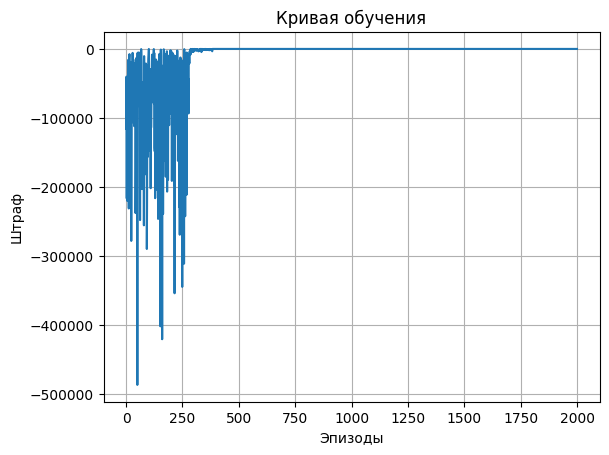

In [50]:
import matplotlib.pyplot as plt

glasses = INITIAL_GLASSES

def state_to_string(state):
    _t = ""
    for s in state:
        _t += f'-{s}'
    return _t[1:]

def action_to_string(action):
    return f'{action[0]}/{action[1]}/{action[2]}'

def describe_action(action):
    return f'Агент переливает {action[2]} мл. компота из стакана № {action[0]+1} в стакан № {action[1]+1}'

def is_equal(glasses):
    for i in range(len(glasses)-1):
        if glasses[i] != glasses[i+1]:
            return False
    return True

def choose_random_action(glasses):
    #print("Генерируем случайное действие для: ", glasses)
    glass_from = rnd.randint(0, GLASSES_COUNT-1)
    #print("Выбран стакан 1: ", glass_from)
    if glasses[glass_from] == 0:
        #print("Он пуст...")
        return choose_random_action(glasses)
    glass_to = rnd.randint(0, GLASSES_COUNT-2)
    if glass_to >= glass_from:
        glass_to += 1
    #print("Выбран стакан 2: ", glass_to)
    glass_compote = rnd.randint(1, glasses[glass_from])
    #print("Решено перелить: ", glass_compote)
    return (glass_from, glass_to, glass_compote)

def pour_compote(ogl, instruction):
    gl = ogl.copy()
    if gl[instruction[0]] >= instruction[2]:
        gl[instruction[0]] -= instruction[2]
        gl[instruction[1]] += instruction[2]
    # else:
    #     glasses[instruction[1]] += glasses[instruction[0]]
    #     glasses[instruction[0]] = 0
    return gl

def get_all_actions(glasses):
    actions = []
    for i in range(0, len(glasses)):
        for j in range(0, len(glasses)):
            if i == j:
                continue
            for k in range(1, glasses[i]+1):
                actions.append(action_to_string((i, j, k)))
    return actions

#ALL_ACTIONS = get_all_actions(INITIAL_GLASSES)

def choose_action(glasses):
    state = state_to_string(glasses)
    #print("Выбираем случайное действие для ", state)
    if state not in Q:
        #print("Такого действия ещё нет, случайная генерация")
        return choose_random_action(glasses)
    
    max_value = max(Q[state].values())
    best_actions = [action for action, value in Q[state].items() if value == max_value]
    choice = rnd.choice(best_actions)
    return (int(choice.split("/")[0]), int(choice.split("/")[1]), int(choice.split("/")[2]))

def update_Q(glasses, action, reward, next_glasses):
    state = state_to_string(glasses)
    next_state = state_to_string(next_glasses)
    if state not in Q:
        Q[state] = {}
        for a in get_all_actions(glasses):
            Q[state][a] = 0

    if next_state not in Q:
        Q[next_state] = {}
        for a in get_all_actions(next_glasses):
            Q[next_state][a] = 0

    if action not in Q[state]:
        ...
        #print(action)
        #print(state)
    
    # Q[state][action_to_string(action)] = Q[state][action_to_string(action)] + ALPHA * (reward + GAMMA * max([Q[state].values()]) - Q[state][action_to_string(action)])
    Q[state][action] = Q[state][action] + ALPHA * (reward + GAMMA * max(Q[next_state].values()) - Q[state][action])

rewards_history = []
for ep in range(NUM_EPISODES):
    glasses = INITIAL_GLASSES.copy()
    # for at in range(NUM_ATTEMPTS):
    at = 0
    while not is_equal(glasses):
        at += 1
        #print("Состояние стаканов:", glasses)
        if is_equal(glasses):
            print(f"Прогон {ep}: стаканы уравновешены c {at}-й попытки")
            rewards_history.append(at)
            break
        action = choose_action(glasses)
        #print(describe_action(action))
        new_glasses = pour_compote(glasses, action)
        update_Q(glasses, action_to_string(action), -1, new_glasses)
        glasses = new_glasses.copy()
    if ep % 100 == 0:
        print(f"Прогоны {ep+1}-{ep+100}")
    rewards_history.append(-at)

plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()

In [ ]:
get_all_actions()

In [51]:
import json

with open("Q.txt", 'w') as file:
    json.dump(Q, file)

with open("rewards_history.txt", 'w') as file:
    json.dump(rewards_history, file)